<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


,text,label
0,Tim Burton is in essence an expressionist film...,1
1,This tale based on two Edgar Allen Poe pieces ...,1
2,"Dead or Alive: Final, the movie that supposedl...",1
3,Certainly this film has the ring of truth abou...,1
4,It pains me to say this about an Australian fi...,0


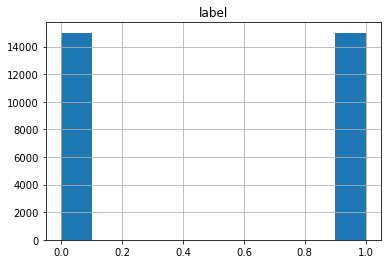

In [1]:
import pandas as pd

df_train = pd.read_json("../data/aclIMDB_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This was Barbra Streisand's first television s...,1
1,"I am, as many are, a fan of Tony Scott films. ...",0
2,A young scientist Harry Harrison is continuing...,0
3,"Anthony McGarten has adapted his play, Via Sat...",1
4,"I was watching this movie on Friday,Apr 7th. I...",1


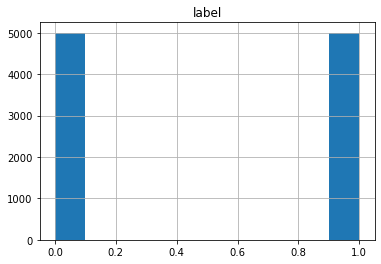

In [2]:
df_val = pd.read_json("../data/aclIMDB_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This movie features Charlie Spradling dancing ...,0
1,L'Hypothèse du tableau volé/The Hypothesis of ...,1
2,Surprisingly well made little movie. Short in ...,1
3,I rented this because I'm a bit weary of '80s ...,0
4,"Twenty years ago, the five years old boy Micha...",0


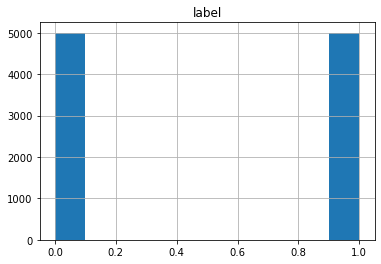

In [3]:
df_test = pd.read_json("../data/aclIMDB_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

In [4]:
train = [str(item).lower() for item in  df_train["text"].values]
val = [str(item).lower() for item in  df_val["text"].values]
test = [str(item).lower() for item in  df_test["text"].values]

In [5]:
import numpy as np
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer

maxlen = 128
tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt", lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

X_train_bert = bert_tokenizer(train)
X_val_bert = bert_tokenizer(val)
X_test_bert = bert_tokenizer(test)

X_train_bert = tf.keras.preprocessing.sequence.pad_sequences(X_train_bert, maxlen=maxlen)
X_val_bert = tf.keras.preprocessing.sequence.pad_sequences(X_val_bert, maxlen=maxlen)
X_test_bert = tf.keras.preprocessing.sequence.pad_sequences(X_test_bert, maxlen=maxlen)

y_train = np.array(df_train["label"].values)
y_val = np.array(df_val["label"].values)
y_test = np.array(df_test["label"].values)

In [6]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_cnn.compile(optimizer='adam',
                  loss="binary_crossentropy",
                  metrics=['binary_accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           976736    
_________________________________________________________________
conv1d (Conv1D)              (None, 122, 32)           7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 991,169
Trainable params: 991,169
Non-trainable params: 0
__________________________________________________

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=2)

h_cnn = model_cnn.fit(X_train_bert, 
                      y_train,
                      epochs=5,
                      batch_size=32,
                      callbacks=[callback],
                      validation_data=(X_val_bert, y_val))

Epoch 1/5
938/938 [==============================] - 10s 9ms/step - loss: 0.5508 - binary_accuracy: 0.6752 - val_loss: 0.3746 - val_binary_accuracy: 0.8309
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.2235 - binary_accuracy: 0.9119 - val_loss: 0.3882 - val_binary_accuracy: 0.8299
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.1088 - binary_accuracy: 0.9624 - val_loss: 0.5125 - val_binary_accuracy: 0.8191


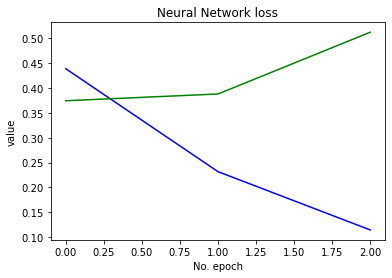

In [8]:
import matplotlib.pyplot as plt

plt.plot(h_cnn.history['loss'], label='(training data)',color='blue')
plt.plot(h_cnn.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

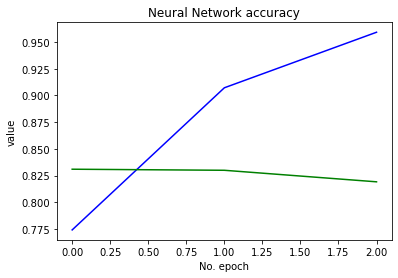

In [9]:
import matplotlib.pyplot as plt

plt.plot(h_cnn.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_cnn.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [10]:
results = model_cnn.evaluate(X_test_bert, y_test, batch_size=32)
print("Simple cnn test loss, test acc:", results)

313/313 [==============================] - 1s 2ms/step - loss: 0.5090 - binary_accuracy: 0.8291
Simple cnn test loss, test acc: [0.50904381275177, 0.8291000127792358]


In [11]:
X_train_bert = bert_tokenizer(train)
X_val_bert = bert_tokenizer(val)
X_test_bert = bert_tokenizer(test)

In [12]:
max_len_avg = [len(item) for item in X_train_bert]
max_len_avg = int(round(sum(max_len_avg) / len(max_len_avg)))
max_len_avg

308

In [13]:
len([item for item in X_train_bert if len(item) <= 512]) / len(X_train_bert)

0.8579

In [14]:
max_len_512 = 512
X_train_bert = tf.keras.preprocessing.sequence.pad_sequences(X_train_bert, maxlen=max_len_512)
X_val_bert = tf.keras.preprocessing.sequence.pad_sequences(X_val_bert, maxlen=max_len_512)
X_test_bert = tf.keras.preprocessing.sequence.pad_sequences(X_test_bert, maxlen=max_len_512)

In [15]:
import tensorflow as tf

emb_size = 32
max_features = 30524 # vocab size

model_cnn_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=max_len_512),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_cnn_gru.compile(optimizer='adam',
                      loss="binary_crossentropy",
                      metrics=['binary_accuracy'])

model_cnn_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 32)           976768    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 506, 32)           7200      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 990,337
Trainable params: 990,337
Non-trainable params: 0
_________________________________________________________________


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=2)

h_cnn_gru = model_cnn_gru.fit(X_train_bert, 
                              y_train,
                              epochs=5,
                              batch_size=32,
                              callbacks=[callback],
                              validation_data=(X_val_bert, y_val))

Epoch 1/5
938/938 [==============================] - 222s 234ms/step - loss: 0.5472 - binary_accuracy: 0.6951 - val_loss: 0.3246 - val_binary_accuracy: 0.8667
Epoch 2/5
938/938 [==============================] - 217s 231ms/step - loss: 0.2100 - binary_accuracy: 0.9219 - val_loss: 0.3130 - val_binary_accuracy: 0.8788
Epoch 3/5
938/938 [==============================] - 192s 204ms/step - loss: 0.1304 - binary_accuracy: 0.9553 - val_loss: 0.3387 - val_binary_accuracy: 0.8741
Epoch 4/5
938/938 [==============================] - 153s 163ms/step - loss: 0.0650 - binary_accuracy: 0.9801 - val_loss: 0.4287 - val_binary_accuracy: 0.8732


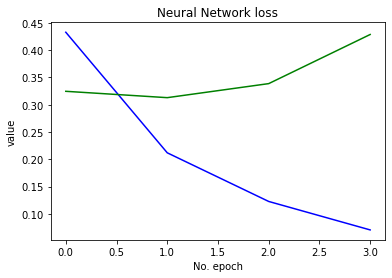

In [17]:
import matplotlib.pyplot as plt

plt.plot(h_cnn_gru.history['loss'], label='(training data)',color='blue')
plt.plot(h_cnn_gru.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

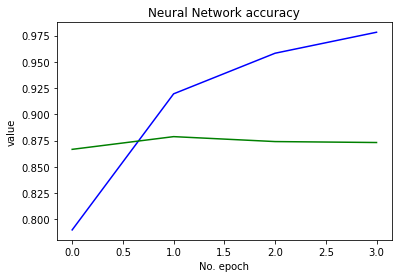

In [18]:
import matplotlib.pyplot as plt

plt.plot(h_cnn_gru.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_cnn_gru.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [19]:
results = model_cnn_gru.evaluate(X_test_bert, y_test, batch_size=32)
print("Simple cnn+gru test loss, test acc:", results)

313/313 [==============================] - 7s 22ms/step - loss: 0.4268 - binary_accuracy: 0.8761
Simple cnn+gru test loss, test acc: [0.4268283247947693, 0.8761000037193298]
